In [1]:
from MALDIMap import MALDINet
from MALDIMap.utils import LoadMSData, SaveMpOrX, PlotCurve

import os
import gc
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from joblib import load, dump

from sklearn.metrics import recall_score,precision_score
from sklearn.metrics import roc_auc_score, accuracy_score, average_precision_score, f1_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV
from sklearn.model_selection import StratifiedKFold,KFold,RepeatedKFold,RepeatedStratifiedKFold, train_test_split
from aggmap import AggMap, AggMapNet

In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]='5'
os.environ['KMP_DUPLICATE_LIB_OK']="TRUE"
physical_gpus = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_gpus[0], True)    #动态调用GPU

In [3]:
root_path = '/raid/lzyt_dir/Data/'#质谱csv和标签路径
save_path = '/mnt/lzyt/SmallSamples'#mp和X保存路径

## Data_10 共1个任务  Neurons：Astrocytes= 684：860

In [13]:
def FilterMassPeaks(df, min_count=None, min_freq=None):
    if min_count is None and min_freq is None:
        raise ValueError("At least one of 'min_count' and 'min_freq' must be provided.")
    elif min_count is not None and min_freq is not None:
        raise ValueError("Only one of 'min_count' and 'min_freq' can be provided.")
        
    # 将NaN替换为0
    df = df.replace(np.nan, 0)
    
    # 计算每列中的非零值数量
    non_zero_counts = df.astype(bool).sum(axis=0)
    
    # 根据最小次数或最小频率筛选列
    if min_count is not None:
        filtered_cols = non_zero_counts[non_zero_counts >= min_count].index
    else:
        thresh = df.shape[0] * min_freq
        filtered_cols = non_zero_counts[non_zero_counts >= thresh].index
    
    return df[filtered_cols]

In [43]:
df = LoadMSData(root_path = root_path, data_path = 'data11/peaks.csv', t = False)
dfx = FilterMassPeaks(df, min_freq=0.5)
dfx

,511.32,512.29,513.32,514.32,518.35,519.3,521.19,522.39,523.38,524.41,...,816.59,817.55,828.52,829.52,830.57,832.65,834.68,835.65,836.67,850.7
0,0.514763,0.360081,0.697731,0.174104,1.562168,0.255871,0.235689,1.334826,0.311429,3.105074,...,0.133913,0.000000,0.257140,0.188382,0.127276,0.000000,0.000000,0.000000,0.000000,0.000000
1,1.216098,0.962318,1.209912,0.282644,1.277035,0.336079,0.881952,1.121939,0.236641,1.600408,...,0.169299,0.000000,0.354255,0.267168,0.159342,0.000000,0.000000,0.000000,0.000000,0.156591
2,0.646368,0.481581,1.278379,0.327409,3.152753,0.646713,0.384198,1.581755,0.292302,2.854120,...,0.204696,0.149469,0.216424,0.182672,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,1.180529,0.652149,2.189925,0.467382,2.244439,0.500761,0.328342,0.873911,0.219871,1.748872,...,0.210043,0.133736,0.231400,0.178794,0.125296,0.121916,0.129621,0.000000,0.117737,0.000000
4,3.058327,2.101446,5.624392,1.406737,2.825733,1.300733,1.437142,1.526937,0.475474,1.624527,...,0.512504,0.521816,1.019437,0.418406,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1539,0.174764,0.121974,0.114341,0.041488,0.327843,0.060638,0.000000,0.325447,0.063021,1.977023,...,0.070047,0.000000,0.090254,0.044239,0.083696,0.095222,0.119889,0.072762,0.096063,0.248563
1540,0.123780,0.000000,0.075884,0.000000,1.136887,0.140555,0.000000,0.290964,0.000000,3.962106,...,0.068992,0.050922,0.050377,0.059558,0.099759,0.065687,0.115058,0.084008,0.073834,0.346894
1541,0.053518,0.033489,0.037723,0.000000,0.472180,0.043014,0.000000,0.780524,0.121685,2.591534,...,0.060716,0.000000,0.050557,0.000000,0.114631,0.175335,0.188875,0.119062,0.185883,0.312129
1542,0.078683,0.040493,0.036112,0.000000,2.815254,0.330708,0.000000,0.354740,0.049155,3.718503,...,0.058220,0.000000,0.036905,0.035197,0.083425,0.092967,0.165887,0.069490,0.146860,0.777661


In [15]:
data2 = pd.read_csv(r'/raid/lzyt_dir/Data/data11/label.csv',header=None)
Labels = np.array(data2)
train_Y = np.zeros((1544,2))                                       #将标签以独热编码存起来1544
test_Y = np.zeros(1544)                                            #用于分层测试的标签
i = 0
for label in Labels:
    ch = str(label)[2]
    if(ch == 'N'):
        train_Y[i,0] = 1
        test_Y[i] = 0
    if(ch == 'A'):
        train_Y[i,1] = 1
        test_Y[i] = 1
    i = i + 1
y = train_Y.astype(int)
Y = test_Y.astype(int)

In [44]:
mp = AggMap(dfx, metric = 'correlation')                        #使用欧式距离
mp.fit(cluster_channels=9, emb_method = 'umap', verbose=0)      #设置通道值
#SaveMpOrX(data = mp, save_path = save_path, data_num = 'data10', file_type = 'aggmap', file_name = 'aggmap_peaks.mp')

2024-01-29 19:33:29,155 - INFO - [bidd-aggmap] - Calculating distance ...
2024-01-29 19:33:29,162 - INFO - [bidd-aggmap] - the number of process is 16


100%|##########| 146/146 [00:00<00:00, 700.02it/s]


2024-01-29 19:33:31,252 - INFO - [bidd-aggmap] - applying hierarchical clustering to obtain group information ...
2024-01-29 19:33:31,487 - INFO - [bidd-aggmap] - Applying grid assignment of feature points, this may take several minutes(1~30 min)
2024-01-29 19:33:31,518 - INFO - [bidd-aggmap] - Finished


In [45]:
# Transoformation of 1d vectors to 3D Fmaps (-1, w, h, c) by AggMap
X = mp.batch_transform(dfx.values, n_jobs=4, scale_method = 'minmax')
#SaveMpOrX(data = X, save_path = save_path, data_num = 'data1', file_type = 'Xdata', file_name = 'X_human_0.2.dat')

100%|##########| 1544/1544 [00:04<00:00, 360.65it/s] 


Auc =  0.7115090816499745
Acc =  0.7152103559870551
f1_score =  0.715210355987055
average_precision =  0.7152103559870551
recall_score =  0.7152103559870551


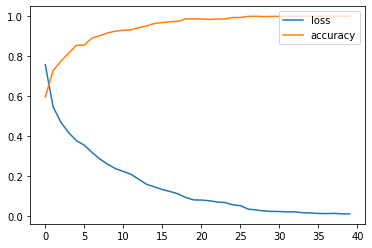

Auc =  0.7186173824478018
Acc =  0.7313915857605178
f1_score =  0.7313915857605178
average_precision =  0.7313915857605178
recall_score =  0.7313915857605178


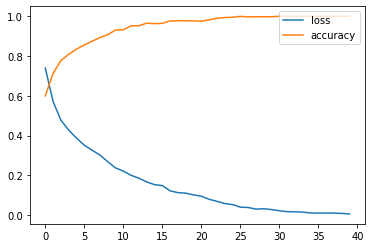

Auc =  0.7471991172975726
Acc =  0.7508090614886731
f1_score =  0.7508090614886731
average_precision =  0.7508090614886731
recall_score =  0.7508090614886731


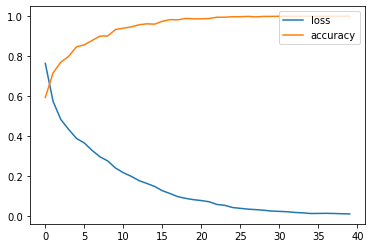

Auc =  0.7033398404345612
Acc =  0.7152103559870551
f1_score =  0.715210355987055
average_precision =  0.7152103559870551
recall_score =  0.7152103559870551


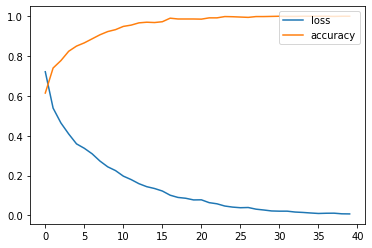

Auc =  0.7527359781121751
Acc =  0.7564935064935064
f1_score =  0.7564935064935063
average_precision =  0.7564935064935064
recall_score =  0.7564935064935064


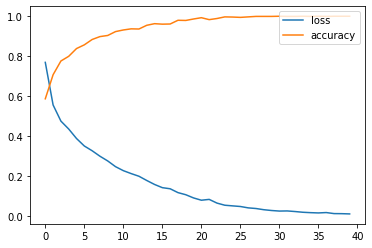

0.7338229731433614

In [54]:
#三核 五折交叉验证最佳结果 0.7338
outer = StratifiedKFold(n_splits = 5,shuffle = True,random_state=42)      #数据集进行分层交叉验证划分训练集和测试集
Sum_acc = 0
for train_index,test_index in outer.split(X,Y):
    train_X,test_X = X[train_index],X[test_index]
    train_Y,test_y = y[train_index],Y[test_index]
    
    clf = MALDINet.MultiClassEstimator(kernel_block='MK',units=[12,24,48],dense_layers=[128],batch_size=128,epochs=40,gpuid=3)
    clf.fit(train_X, train_Y)

    y_pred = clf.predict(test_X)
    #MADLINet Test Metrics
    auc = roc_auc_score(test_y, y_pred)
    acc = accuracy_score(test_y,y_pred)
    rec = recall_score(test_y, y_pred,average="micro")
    f1 = f1_score(test_y, y_pred,average="micro")
    pr = precision_score(test_y, y_pred,average="micro")
    print("Auc = ",auc)
    print("Acc = ",acc)
    print("f1_score = ",f1)
    print("average_precision = ",pr)
    print("recall_score = ",rec)
    Sum_acc += acc
    #plot train curve
    PlotCurve(clf.history)
Sum_acc / 5